In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
import os
import pickle
from tqdm import tqdm
import networkx as nx

In [3]:
import torch

In [50]:
X_torch = torch.randn(1000, 3, requires_grad=True)
X = X_torch.detach().numpy()
median = np.array(hd.geomedian(X, axis=0))
D = np.linalg.norm(X - median, axis=1)
D_inv = 1 / D
D_inv[D_inv == np.inf] = 0.
W = D_inv / D_inv.sum()
median = torch.tensor(W) @ X_torch

In [51]:
W

array([0.00129604, 0.0009221 , 0.0004946 , 0.00064771, 0.00047499,
       0.00054705, 0.00159102, 0.00119209, 0.00085293, 0.00064732,
       0.00116265, 0.00072128, 0.00060517, 0.00108208, 0.00083228,
       0.00203982, 0.00143169, 0.00087788, 0.00116047, 0.00062516,
       0.0008001 , 0.00080588, 0.00040404, 0.00131384, 0.0010322 ,
       0.0005077 , 0.00045894, 0.00078929, 0.00107546, 0.00090073,
       0.00064145, 0.00078557, 0.0006365 , 0.00065381, 0.00204378,
       0.00136121, 0.00194422, 0.00058767, 0.00106452, 0.00081255,
       0.00050198, 0.00136944, 0.00041961, 0.0025572 , 0.00399312,
       0.00045626, 0.00223357, 0.00077525, 0.00053439, 0.0019489 ,
       0.00059625, 0.00082485, 0.00066122, 0.0005317 , 0.00097057,
       0.00106333, 0.00196882, 0.00152205, 0.00196082, 0.00058521,
       0.00071954, 0.00121645, 0.00059846, 0.00116989, 0.00227131,
       0.00067376, 0.00128962, 0.00061061, 0.00045214, 0.00194309,
       0.00118185, 0.00074017, 0.00107703, 0.0005745 , 0.00042

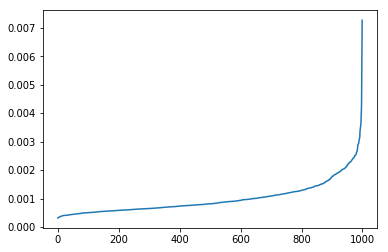

In [56]:
plt.plot(np.sort(W));

In [58]:
1 / len(W)

0.001

In [43]:
median.norm().backward()

In [44]:
X_torch.grad

tensor(1.00000e-03 *
       [[ 0.6463, -0.5478,  0.3453],
        [ 0.6058, -0.5135,  0.3237],
        [ 1.0084, -0.8548,  0.5387],
        ...,
        [ 0.3808, -0.3228,  0.2034],
        [ 1.2504, -1.0599,  0.6680],
        [ 0.5298, -0.4490,  0.2830]])

In [736]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output
from tools.opera_tools import plot_graphx, DISTANCE
process = psutil.Process(os.getpid())

In [737]:
import pickle

In [740]:
with open('./ship/selected_showers.pickle', 'rb') as f:
    selected_showers = pickle.load(f)

In [741]:
bricks = []

In [1036]:
NUM_SHOWERS_IN_BRICK = 200

In [1037]:
%%time
bricks = []
for i in range(len(selected_showers) // NUM_SHOWERS_IN_BRICK):
    node_id = 0
    graphx = nx.DiGraph()
    nodes_to_add = []
    showers_data = []
    for j in range(NUM_SHOWERS_IN_BRICK):
        selected_shower = selected_showers[i * NUM_SHOWERS_IN_BRICK + j]
        showers_data.append(
            {
            'numtracks': len(selected_shower['PX']),
            'signal': j
            }
        )
        for k in range(len(selected_shower['PX'])):
            nodes_to_add.append(
                (
                    node_id,
                    {
                        'features': {
                            'SX': selected_shower['TX'][k] * 10000,
                            'SY': selected_shower['TY'][k] * 10000,
                            'SZ': selected_shower['TZ'][k] * 10000,
                            'TX': selected_shower['PX'][k] / selected_shower['PZ'][k],
                            'TY': selected_shower['PY'][k] / selected_shower['PZ'][k],
                        },
                        'signal': j
                    }
                )
            )
            node_id += 1
    graphx.add_nodes_from(nodes_to_add)
    graphx.graph['showers_data'] = showers_data
    bricks.append(graphx)
    break

CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 277 ms


## Функция подсчёта метрики

In [1038]:
DISTANCE

1293.0

In [1039]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [1040]:
%%cython --cplus --compile-args=-fopenmp --link-args=-fopenmp  -f --compile-args=-DCYTHON_TRACE=1
# -a
cimport cython
import numpy as np
cimport numpy as np
from cython.parallel import prange
from libc.math cimport sqrt, fabs, log
import networkx
from libcpp.vector cimport vector
from tqdm import tqdm
from tools.opera_tools import DISTANCE
# SX, SY, SZ, TX, TY
#  0,  1,  2,  3,  4
@cython.linetrace(True)
@cython.binding(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
cdef double rms_integral_root_closed(vector[double] basetrack_left, vector[double] basetrack_right):
    cdef double dz = basetrack_right[2] - basetrack_left[2]
    cdef double dx = basetrack_left[0] - (basetrack_right[0] - basetrack_right[3] * dz)
    cdef double dy = basetrack_left[1] - (basetrack_right[1] - basetrack_right[4] * dz)
    cdef double dtx = (basetrack_left[3] - basetrack_right[3])
    cdef double dty = (basetrack_left[4] - basetrack_right[4])
    
    cdef double euclidian_distance = sqrt(dx**2 + dy**2 + dz**2)
    cdef double angle_distance = sqrt(dtx**2 + dty**2)
    
    # dz can be assigned to arbitrary value, acutally!
    dz = DISTANCE
    cdef double a = (dtx * dz) ** 2 + (dty * dz) ** 2
    cdef double b = 2 * (dtx * dz * dx +  dty * dz * dy)
    cdef double c = dx ** 2 + dy ** 2
    if a == 0.:
        return fabs(sqrt(c))# / angle_distance + euclidian_distance
    cdef double discriminant = (b ** 2 - 4 * a * c)
    cdef double log_denominator = 2 * sqrt(a) * sqrt(a + b + c) + 2 * a + b 
    cdef double log_numerator = 2 * sqrt(a) * sqrt(c) + b
    cdef double first_part = ( (2 * a + b) * sqrt(a + b + c) - b * sqrt(c) ) / (4 * a)

    
    cdef rms = fabs((discriminant * log(log_numerator / log_denominator) / (8 * sqrt(a * a * a)) + first_part))
    cdef double total_loss = rms# * angle_distance # * euclidian_distance
    return total_loss

@cython.linetrace(True)
@cython.binding(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
cdef vector[double] node_to_vector(node, median=False):
    if median:
        return [node['features']['SX'], 
             node['features']['SY'], 
             node['features']['SZ'], 
             node['features']['TX_m'], 
             node['features']['TY_m']]
    else:
        return [node['features']['SX'], 
             node['features']['SY'], 
             node['features']['SZ'], 
             node['features']['TX'], 
             node['features']['TY']]

@cython.linetrace(True)
@cython.binding(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def generate_distances(graphx_nodes, threshold=2000, layers=3):
    cdef int N = len(graphx_nodes)
    cdef int i, j
    cdef double r
    ebunch = []
    graphx_nodes_preprocessed = []
    for i in range(N):
        node_id, node = graphx_nodes[i]
        node = node_to_vector(node)
        graphx_nodes_preprocessed.append((node_id, node))

    for i in tqdm(range(N)):
        node_id_left, node_left = graphx_nodes_preprocessed[i]
        for j in range(i):
            node_id_right, node_right = graphx_nodes_preprocessed[j]

            if node_right[2] > node_left[2] and  node_right[2] - node_left[2] <= DISTANCE * layers:
                r = rms_integral_root_closed(node_left, node_right)
                # ... and those who is a bad match
                if r < threshold:
                    ebunch.append((node_id_left, 
                                   node_id_right, 
                                   {'weight': r}))
                    
            elif node_left[2] > node_right[2] and node_left[2] - node_right[2] <= DISTANCE * layers:
                r = rms_integral_root_closed(node_right, node_left)
                # ... and those who is a bad match
                if r < threshold:
                    ebunch.append((node_id_left, 
                                   node_id_right, 
                                   {'weight': r}))
            else:
                pass
            
    return ebunch

## Подсчёт матрицы расстояний

Матрица расстояний считается для всех пар треков, таких что один трек следует за другим. 

То есть если трек_1 в пластине 1, а трек_2 в пластине 2, то они будут соединены ребром от трека_1 до трека_2, но ребра от трека_2 до трека_1 не будет.

Сложность $\sim O(n^2)$

In [1041]:
graphx_nodes = list(graphx.nodes(data=True))

In [1117]:
ebunch = generate_distances(graphx_nodes, layers=3, threshold=200)

100%|██████████| 53185/53185 [03:57<00:00, 223.60it/s] 


In [1118]:
G = nx.DiGraph()
G.add_edges_from(ebunch)

In [1119]:
for node_id in G.nodes():
    G.node[node_id].update(graphx.node[node_id])

In [1120]:
connected_components = []
for cnn in nx.connected_components(nx.Graph(G)):
    if len(cnn) > 30:
        connected_components.append(G.subgraph(cnn))

In [1121]:
def class_disbalance_graphx(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

In [1122]:
for i, connected_component in enumerate(connected_components):
    print(i, class_disbalance_graphx(connected_component))

0 [(0, 391)]
1 [(1, 1226), (174, 566)]
2 [(2, 45)]
3 [(3, 38)]
4 [(4, 784), (115, 377)]
5 [(5, 42)]
6 [(6, 249)]
7 [(7, 38)]
8 [(8, 1052)]
9 [(8, 38)]
10 [(9, 680)]
11 [(10, 756), (92, 1408)]
12 [(11, 109)]
13 [(12, 15), (96, 218)]
14 [(12, 51)]
15 [(13, 1026), (75, 55)]
16 [(14, 43)]
17 [(15, 870), (27, 379), (176, 62)]
18 [(16, 422), (166, 6)]
19 [(17, 491), (179, 64)]
20 [(18, 38), (111, 9)]
21 [(19, 32)]
22 [(20, 65), (121, 1481)]
23 [(21, 43)]
24 [(22, 146), (172, 885), (197, 322)]
25 [(22, 35)]
26 [(23, 38)]
27 [(24, 150)]
28 [(25, 201)]
29 [(25, 108)]
30 [(26, 78), (70, 135), (109, 609)]
31 [(27, 36)]
32 [(28, 539)]
33 [(29, 393)]
34 [(30, 62)]
35 [(31, 137)]
36 [(31, 45)]
37 [(31, 56)]
38 [(32, 377), (169, 66)]
39 [(33, 40), (43, 377)]
40 [(36, 703)]
41 [(37, 76)]
42 [(37, 72)]
43 [(38, 209)]
44 [(39, 75)]
45 [(40, 41)]
46 [(41, 154)]
47 [(41, 38)]
48 [(42, 503)]
49 [(42, 5), (198, 59)]
50 [(45, 94)]
51 [(46, 75)]
52 [(47, 48), (57, 1)]
53 [(48, 362), (91, 263), (178, 969)]
54 

106


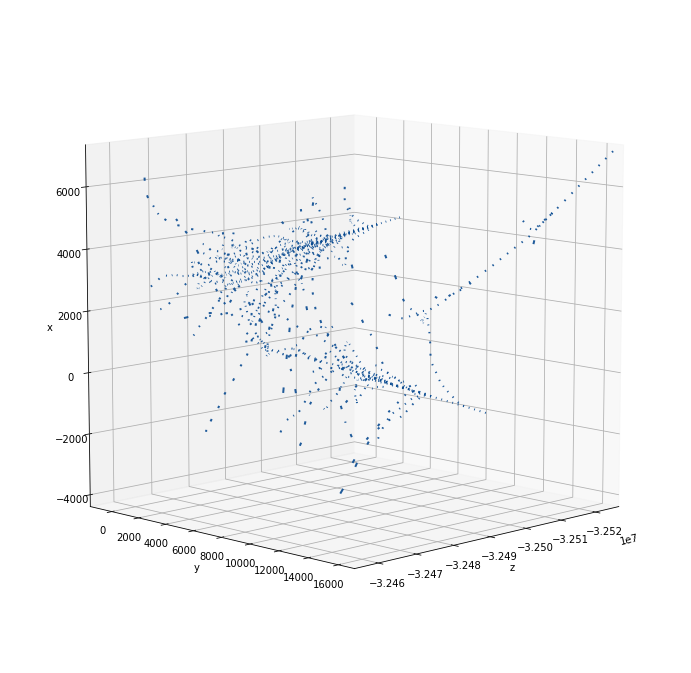

In [1160]:
i=106
print(i)
plot_graphx(connected_components[i], azim=45)

In [1161]:
G = connected_components[106]

## Строим граф попарных расстояний

Расстояние между двумя треками = максимум(ядровое расстояние трека_1, ядровое расстояние трека_1, расстояние(трек_1, трек_2)).

Такое определение расстояния обеспечивает робастность в алгоритме HDBSCAN.

In [1162]:
# create self loops for HDBSCAN algorithm
# for node_id in tqdm(core_k.keys()):
#    G.add_edge(node_id, node_id, weight=core_k[node_id])

In [1163]:
from math import fabs, sqrt, log
def rms_integral_root_closed_py(basetrack_left, basetrack_right, 
                             TX_LEFT='TX', TY_LEFT='TY',
                             TX_RIGHT='TX', TY_RIGHT='TY'):
    EPS = 1e-6
    dz = basetrack_right['features']['SZ'] - basetrack_left['features']['SZ']
    dx = basetrack_left['features']['SX'] - (basetrack_right['features']['SX'] - basetrack_right['features'][TX_RIGHT] * dz)
    dy = basetrack_left['features']['SY'] - (basetrack_right['features']['SY'] - basetrack_right['features'][TY_RIGHT] * dz)
    dtx = (basetrack_left['features'][TX_LEFT] - basetrack_right['features'][TX_RIGHT])
    dty = (basetrack_left['features'][TX_LEFT] - basetrack_right['features'][TY_RIGHT])
    # dz can be assigned to arbitrary value, acutally !
    dz = DISTANCE
    a = (dtx * dz) ** 2 + (dty * dz) ** 2
    b = 2 * (dtx * dz * dx +  dty * dz * dy)
    c = dx ** 2 + dy ** 2
    if a == 0.:
        return fabs(sqrt(c))
    discriminant = (b ** 2 - 4 * a * c)
    log_denominator = 2 * sqrt(a) * sqrt(a + b + c) + 2 * a + b 
    log_numerator = 2 * sqrt(a) * sqrt(c) + b + EPS
    first_part = ( (2 * a + b) * sqrt(a + b + c) - b * sqrt(c) ) / (4 * a)
    return fabs((discriminant * log(log_numerator / log_denominator) / (8 * sqrt(a * a * a)) + first_part))


In [1164]:
from nmp.nmp_tools import unique_neighbours_of_k_order

In [1165]:
%%time
for node_id_left, node_id_right, edge in tqdm(G.edges(data=True)):
    node_left = G.node[node_id_left]
    node_right = G.node[node_id_right]
    if node_left['features']['SZ'] == node_right['features']['SZ']:
        continue
    if node_left['features']['SZ'] > node_right['features']['SZ']:
        node_left, node_right = node_right, node_left
    edge['weight'] = rms_integral_root_closed_py(node_left, node_right)
    edge['Z_start'] = node_left['features']['SZ']
    edge['Z_end'] = node_right['features']['SZ']

100%|██████████| 4173/4173 [00:00<00:00, 44228.44it/s]

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 103 ms


## Вытаскиваем рёбра из минимального остова

## Объявляем необходимые структуры данных для кластеризации

In [1166]:
from collections import Counter

In [1167]:
from copy import deepcopy      
        
class ClusterHDBSCAN(object):
    def __init__(self, weight: float, cl_size: int, clusters: list = None, nodes: list = None):
        # init
        self.nodes = set()
        self.nodes_in = Counter()
        self.nodes_out = Counter()
        
        self.weights_nodes_dict = defaultdict(set)
        
        self.weight_death = weight
        self.lambda_death = 1. / weight
        
        self.weight_birth = weight
        self.lambda_birth = 1. / weight
        
        
        self.children = []
        self.falling_out_points = []
        
        assert clusters is not None or nodes is not None
        if clusters is not None:
            for cluster in clusters:
                self.nodes.update(cluster.nodes)
                self.nodes_in.update(cluster.nodes_in)
                self.nodes_out.update(cluster.nodes_out)
                self.weights_nodes_dict[weight].update(cluster.nodes)
                if cluster.is_cluster:
                    cluster.set_weight_birth(weight)
                    self.children.append(cluster)
                else:
                    self.falling_out_points.append(cluster)
        else:
            self.nodes.update(nodes)
            self.nodes_out.update(nodes)
            self.weights_nodes_dict[weight].update(nodes)
            
        self.is_cluster = len(self) >= cl_size
        self.is_noise = not self.is_cluster
        self.stability = None
        
        
    def append(self, weight: float, clusters: list):
        """
        Adding
        """
        for cluster in clusters:
            self.nodes.update(cluster.nodes)
            self.weights_nodes_dict[weight].update(cluster.nodes)
        self.weight_birth = weight
        self.lambda_birth = 1 / weight
        return self
    
    def __iter__(self):
        for child in self.children:
            yield child
    
    def __contains__(self, node):
        return node in self.nodes
    
    def __len__(self):
        return len(self.nodes)
    
    def set_weight_birth(self, weight: float):
        self.weight_birth = weight
        self.lambda_birth = 1 / weight
        
    def calculate_stability(self):
        self.stability = 0.
        self.lambda_birth = 1 / max(self.weights_nodes_dict.keys())
        for weight in self.weights_nodes_dict:
            self.stability += len(self.weights_nodes_dict[weight]) * (1. / weight - self.lambda_birth)

In [1168]:
def recalc_tree(root):
    root
    weights_children = 0
    for child in root:
        weights_children += recalc_tree(child)
    if weights_children > root.stability:
        root.stability = weights_children
    else:
        root.children.clear()
    
    return root.stability
def run_hdbscan(G, cl_size=20):
    ####### core_d was deleted => could be returned. Laverage robustness / cluster shaprness.
    
    for node_id_left, node_id_right, edge in G.edges(data=True):
        node_left = G.node[node_id_left]
        node_right = G.node[node_id_right]
        if node_left['features']['SZ'] == node_right['features']['SZ']:
            continue
        if node_left['features']['SZ'] > node_right['features']['SZ']:
            node_left, node_right = node_right, node_left
        edge['weight'] = rms_integral_root_closed_py(node_left, node_right)
        edge['Z_start'] = node_left['features']['SZ']
        edge['Z_end'] = node_right['features']['SZ']


    edges = list(G.edges(data=True))
    edges = [(edge[0], # 0
              edge[1], # 1
              edge[2]['weight'], # 2
              edge[2]['Z_start'], # 3
              edge[2]['Z_end'], # 4
              edge[2]['Z_end'] - edge[2]['Z_start'] # 5
             ) for edge in edges]
    import operator
    edges = sorted(edges, key = operator.itemgetter(2, 3, 5))
    from collections import Counter

    ### Minimum spanning tree was also thrown
    ### following algo reminds of Kruskal algo but with some modifications
    tmp = Counter()
    new_edges = []
    for edge in edges:
        new_edges.append(
            (
                edge[0],
                edge[1],
                edge[2],# * (1 + tmp[edge[1]]), ## tunable parameter. TODO
                edge[3],
                edge[4],
                edge[5]
            )
        )
        tmp[edge[1]] += 1
    ### TODO: sort on some mix(i.e. linear) of Z_coord and integrated distance
    edges = sorted(new_edges, key = operator.itemgetter(3, 2, 5))


    # init
    clusters = {}
    for node_id in G.nodes():
        clusters[node_id]=ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id])


    for i, j, weight, z_min, z_max, z_diff in edges:
        cluster_out = clusters[i]
        cluster_in = clusters[j]

        ### tunable parameter
        if cluster_in.nodes_in[j] > 1:
            continue

        if cluster_in is cluster_out:
            continue

        if cluster_in.is_cluster and cluster_out.is_cluster:
            cluster = ClusterHDBSCAN(weight=weight , cl_size=cl_size, clusters=[cluster_in, cluster_out])
        elif cluster_in.is_cluster and not cluster_out.is_cluster:
            cluster = cluster_in.append(weight=weight, clusters=[cluster_out])
        elif cluster_out.is_cluster and not cluster_in.is_cluster:
            cluster = cluster_out.append(weight=weight, clusters=[cluster_in])
        else:
            cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=[cluster_in, cluster_out])

        cluster.nodes_out[i] += 1
        cluster.nodes_in[j] += 1

        clusters.update({l: cluster for l in cluster.nodes})
        
    clusters = list(set(clusters.values()))

    ### choose biggest cluster
    root = clusters[0]
    length = len(clusters[0])
    for cluster in clusters:
        if len(cluster) > length:
            length = len(cluster)
            root = cluster
    
    calc_stabilities(root)
    
    clusters = list(leaf_clusters(root))
    print(len(clusters))
    return root, clusters

In [1169]:
root, clusters = run_hdbscan(G)

3


In [1170]:
class_disbalance_graphx(G)

[(104, 738), (195, 356), (196, 44)]

In [1171]:
for cluster in clusters:
    print(class_disbalance(cluster, G))

[(104, 668)]
[(195, 224)]
[(195, 1), (196, 42)]


In [1135]:
print_class_disbalance_for_all_clusters(root, G)

len=1308
[(15, 870), (27, 376), (176, 62)] stability=14.425
+---len=395
    [(15, 395)] stability=9.796
+---len=402
    [(15, 5), (27, 338), (176, 59)] stability=1.721
    +---len=47
        [(27, 2), (176, 45)] stability=0.110
    +---len=314
        [(27, 313), (176, 1)] stability=5.438


## Стабильности

In [1088]:
def class_disbalance(cluster, graph):
    subgraph = graph.subgraph(cluster.nodes)
    signal = []
    for _, node in subgraph.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def flat_clusters(root):
    if root.is_cluster:
        yield root
        
    for child in root:
        for cluster in flat_clusters(child):
            yield cluster
            
def reed_stabilities(root, level=0):
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)), end=' ')
    print('stability={:.2f}'.format(root.stability))
    for child in root:
        reed_stabilities(child, level + 1)

def print_class_disbalance_for_all_clusters(root, graph, level=0):
    class_disbalance_tuples = class_disbalance(root, graph)

    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples, end=' ')
    print('stability={:.3f}'.format(root.stability))
    for child in root:
        print_class_disbalance_for_all_clusters(child, graph, level + 1)
        
def leaf_clusters(root):
    if root.is_cluster and len(root.children) == 0:
        yield root
        
    for child in root:
        for cluster in leaf_clusters(child):
            yield cluster

def max_level_clusters(root, level=0, max_level=2):
    if level == max_level and root.is_cluster:
        yield root
        
    for child in root:
        for cluster in max_level_clusters(child, level=level+1, max_level=max_level):
            yield cluster

In [881]:
list(leaf_clusters(root))

len=2506
[(1, 1355), (31, 253), (154, 107), (174, 641), (199, 150)] stability=0.766
+---len=2342
    [(1, 1344), (31, 253), (154, 107), (174, 638)] stability=3.671
    +---len=239
        [(1, 3), (31, 236)] stability=0.147
        +---len=64
            [(31, 64)] stability=0.262
        +---len=168
            [(1, 2), (31, 166)] stability=0.112
            +---len=121
                [(1, 1), (31, 120)] stability=0.698
            +---len=37
                [(31, 37)] stability=0.074
    +---len=1981
        [(1, 1255), (31, 3), (154, 104), (174, 619)] stability=1.607
        +---len=101
            [(154, 101)] stability=0.572
        +---len=1809
            [(1, 1199), (31, 3), (154, 1), (174, 606)] stability=16.700
            +---len=575
                [(1, 566), (174, 9)] stability=1.184
                +---len=466
                    [(1, 466)] stability=20.069
                    +---len=39
                        [(1, 39)] stability=1.627
                    +---len=41
   

In [883]:
recalc_tree(root)

23.62520644451483

In [869]:
print_class_disbalance_for_all_clusters(root, G)

len=2506
[(1, 1355), (31, 253), (154, 107), (174, 641), (199, 150)] stability=23.625


In [782]:
def plot_class_disbalance_for_all_clusters(root, graph, level=0):
    
    class_disbalance_tuples = class_disbalance(root, graph)
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples)
    print()
    
    subgraph = graph.subgraph(root.nodes)
    plot_graphx(subgraph, elev=70)
    
    for child in root:
        plot_class_disbalance_for_all_clusters(child, graph, level + 1)

len=2506
[(1, 1355), (31, 253), (154, 107), (174, 641), (199, 150)]



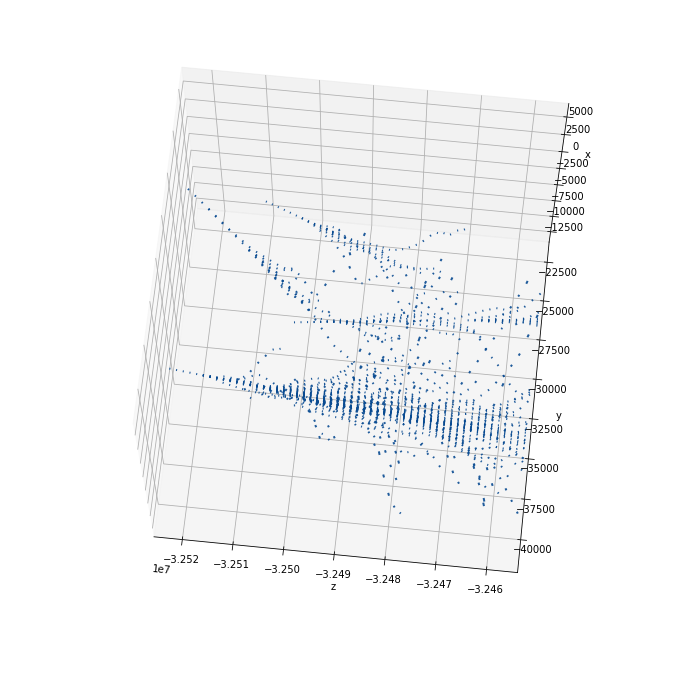

+---len=43
    [(31, 43)]



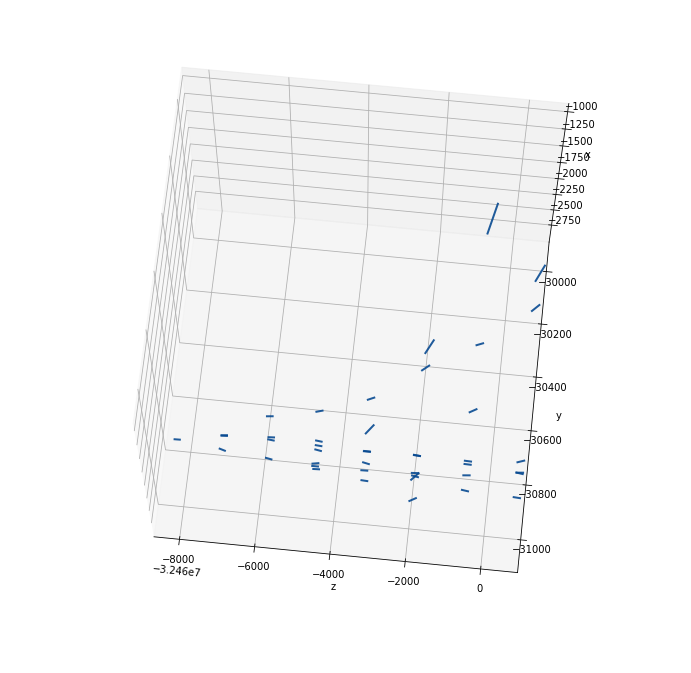

+---len=2354
    [(1, 1334), (31, 184), (154, 107), (174, 579), (199, 150)]



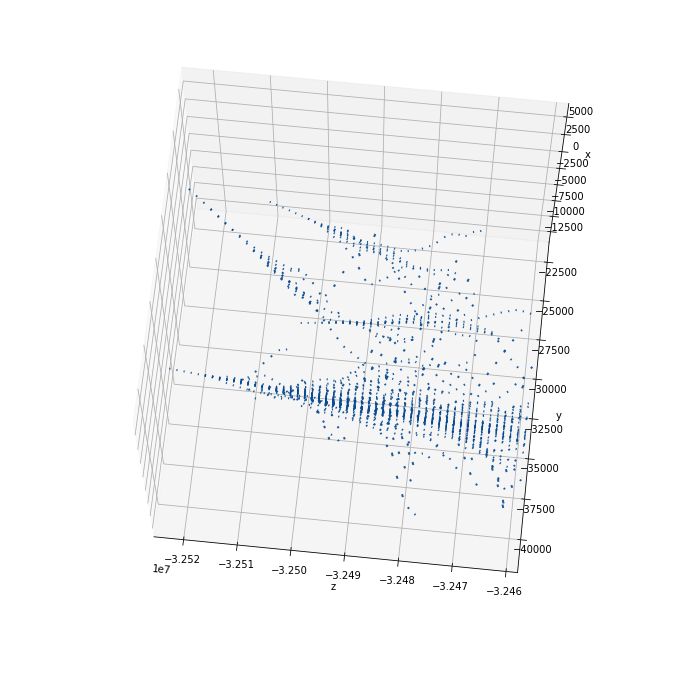

    +---len=1573
        [(1, 1081), (31, 130), (154, 107), (174, 255)]



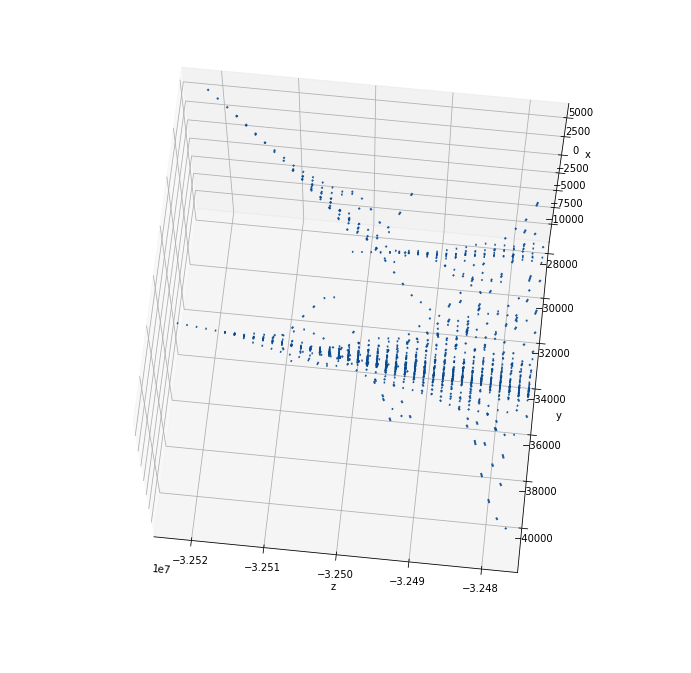

        +---len=1202
            [(1, 925), (154, 107), (174, 170)]



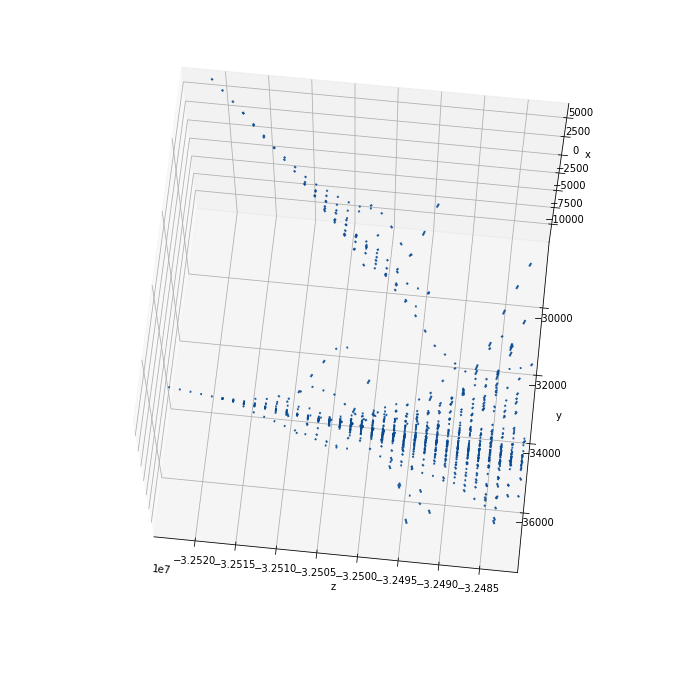

            +---len=106
                [(154, 106)]



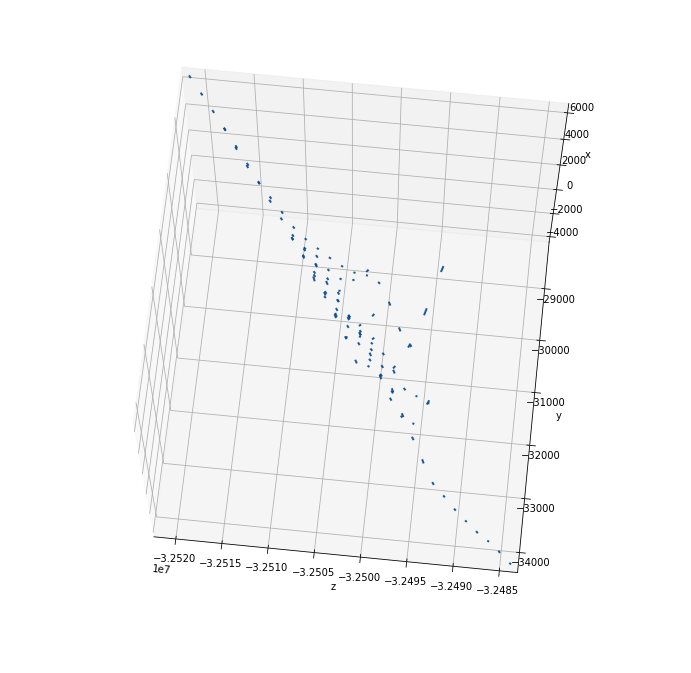

            +---len=1096
                [(1, 925), (154, 1), (174, 170)]



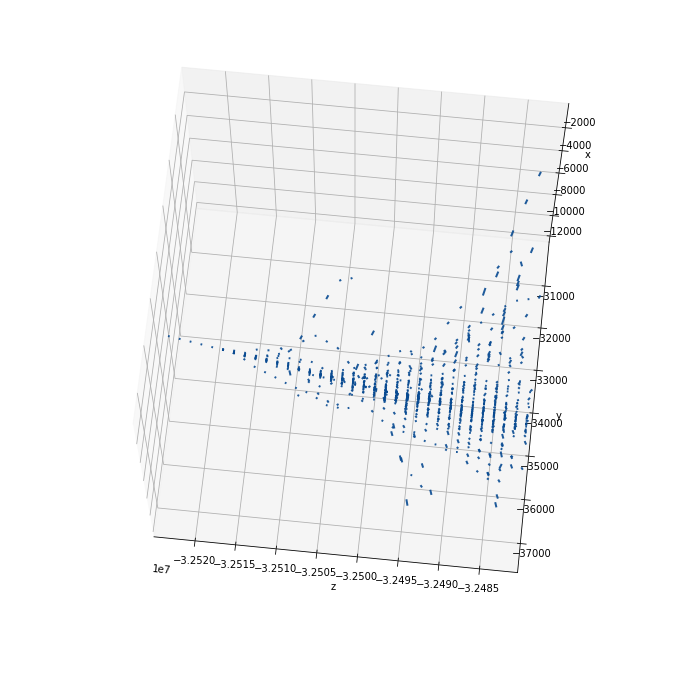

        +---len=99
            [(1, 1), (31, 98)]



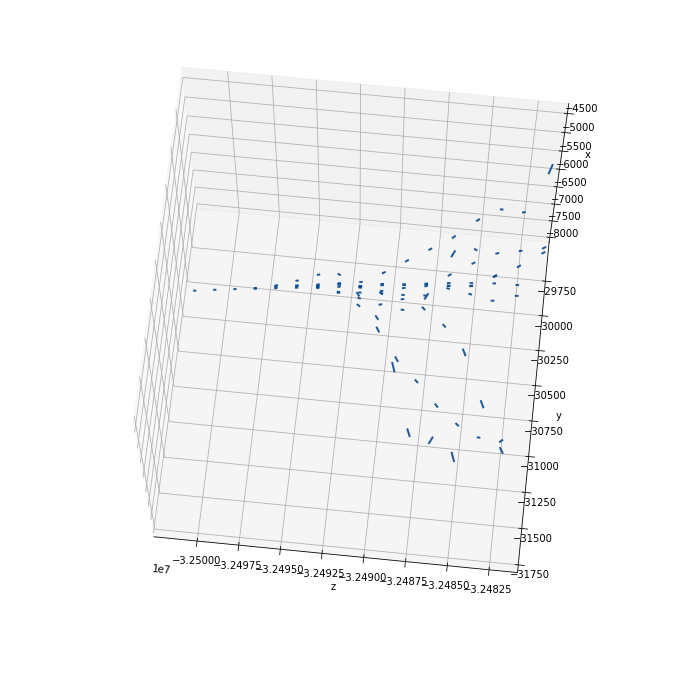

    +---len=143
        [(1, 1), (199, 142)]



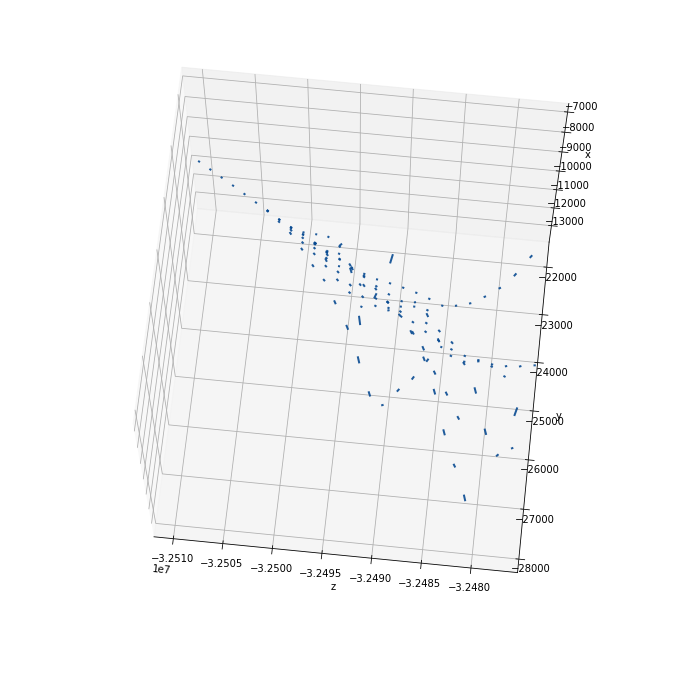

In [783]:
plot_class_disbalance_for_all_clusters(root, G)